#Fall 2024 AIN433 Assignment 1
**Student:** Mehmet Ertaş - 2200765035

**Instructor:** Ali Seydi Keçeli

**TA:** Sibel Kapan

#Imports and Data Load

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import convolve
import cv2
import os
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skimage import filters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Loading Data

In [ ]:
labels = ['street', 'sea', 'mountain', 'glacier', 'forest', 'buildings']
X_train = []
y_train = []
X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/intel_image_dataset/train/',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/intel_image_dataset/test/',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        X_test.append(img)
        y_test.append(i)

100%|██████████| 437/437 [00:08<00:00, 50.65it/s] 


#Functions

##Base Image Altering Functions

In [ ]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

##Gradient Filtering Functions

###Sobel Filter

In [ ]:
#A function that returns gradX and gradY: two arrays that shows the x and y gradients of given image
def sobelFilter(image):
  #Sobel filters for X and Y gradients
    sobelX = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]])

    sobelY = np.array([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]])

    #Filtering the image using X and Y filters
    gradX = convolve(image, sobelX)
    gradY = convolve(image, sobelY)

    return gradX, gradY

###Prewitt Filter

In [ ]:
#A function that returns gradX and gradY: two arrays that shows the x and y gradients of given image
def prewittFilter(image):
    #Previtt filters for X and Y gradients
    prewittX = np.array([[ -1, 0, 1],
                         [ -1, 0, 1],
                         [ -1, 0, 1]])

    prewittY = np.array([[  1, 1, 1],
                         [  0, 0, 0],
                         [ -1, -1, -1]])

    #Filtering the image using X and Y filters
    gradX = convolve(image, prewittX)
    gradY = convolve(image, prewittY)

    return gradX, gradY

##Magnitude and Orientation finding Function

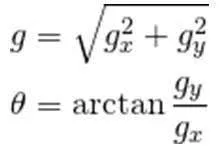

In [ ]:
#A function that returns magnitude and orientation given X and Y gradients of an image
def magAndOri(gradX,gradY):
    mag = np.sqrt(gradX ** 2 + gradY ** 2)

    ori = np.rad2deg(np.arctan2(gradY, gradX)) % 180

    return mag, ori

##Grid Dividing Function

In [ ]:
#A function that divides the image into Row x Col grid and returns them in an array
def gridDivider(image, gridRow = 4, gridCol = 4):
    h, w = image.shape
    gridH, gridW = h // gridRow, w // gridCol #By default it is 4x4 grid

    grids = []
    for i in range(gridRow):
        for j in range(gridCol):
            grid = image[i*gridH:(i+1)*gridH, j*gridW:(j+1)*gridW]
            grids.append(grid)

    return grids

##Histogram Functions

###Histogram Plotter

In [ ]:
#A function that returns the histogram of given image based on the angle of the orientation.
def compute_histograms(mag, ori, num_bins=9):
    h, w = mag.shape
    bin_width = 180 / num_bins
    histogram = np.zeros(num_bins)

    for i in range(h):
        for j in range(w):
            angle = ori[i, j]
            bin_idx = int(angle // bin_width)
            histogram[bin_idx] += mag[i, j]

    return histogram

###Histogram Normalizing and Rotatoing Functions

In [ ]:
#A function that returns normalized histogram
def normalize_histogram(histogram):
    norm = np.linalg.norm(histogram)
    return histogram / (norm + 1e-6)

#A function that returns rotated histogram where the maximum gradient is at start
#While the pdf says to put it in middle, the figures showed it at the start so I used that as a base.
def rotate_histogram(histogram):
    max_bin_index = np.argmax(histogram)
    return np.roll(histogram, -max_bin_index)

##HoG Function

In [ ]:
#A function that returns 1d vector that is usable by logistic regression or naive bayes classifier
def compute_hog_features(image, target =(1024,1024), gridRow = 4, gridCol = 4, filter_type='sobel'):
  #Turning it grayscale
  grayImage = grayscale(image)

  #Dividing into grids
  grids = gridDivider(grayImage, gridRow, gridCol)

  histograms = []
  for grid in grids:
    if filter_type == 'sobel':
      gradX, gradY = sobelFilter(grid)
    elif filter_type == 'prewitt':
      gradX, gradY = prewittFilter(grid)
    mag, ori = magAndOri(gradX, gradY)

    histogram = compute_histograms(mag, ori)
    normalized_hist = normalize_histogram(histogram)  #Normalize histogram
    rotated_hist = rotate_histogram(normalized_hist)  #Rotate histogram
    histograms.append(rotated_hist)

  return np.concatenate(histograms)  #Return a 1d vector so that we can use it later

#3x3 Grid Tests

##Sobel

In [ ]:
x_train_hog_3s = []
for img in tqdm(X_train):
    hog_features = compute_hog_features(img, gridRow = 3, gridCol = 3, filter_type='sobel')
    x_train_hog_3s.append(hog_features)

100%|██████████| 14034/14034 [17:47<00:00, 13.14it/s]


In [ ]:
x_test_hog_3s = []
for img in tqdm(X_test):
    hog_features = compute_hog_features(img, gridRow = 3, gridCol = 3, filter_type='sobel')
    x_test_hog_3s.append(hog_features)

100%|██████████| 3000/3000 [03:47<00:00, 13.18it/s]


In [ ]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(x_train_hog_3s, y_train)
y_pred_nb = naive_bayes_classifier.predict(x_test_hog_3s)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.2f}')

Naive Bayes Accuracy: 0.45


In [ ]:
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(x_train_hog_3s, y_train)
y_pred_lr = logistic_regression_classifier.predict(x_test_hog_3s)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')

Logistic Regression Accuracy: 0.54


##Prewitt

In [ ]:
x_train_hog_3p = []
for img in tqdm(X_train):
    hog_features = compute_hog_features(img, gridRow = 3, gridCol = 3, filter_type='prewitt')
    x_train_hog_3p.append(hog_features)

100%|██████████| 14034/14034 [17:39<00:00, 13.24it/s]


In [ ]:
x_test_hog_3p = []
for img in tqdm(X_test):
    hog_features = compute_hog_features(img, gridRow = 3, gridCol = 3, filter_type='prewitt')
    x_test_hog_3p.append(hog_features)

100%|██████████| 3000/3000 [03:47<00:00, 13.20it/s]


In [ ]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(x_train_hog_3p, y_train)
y_pred_nb = naive_bayes_classifier.predict(x_test_hog_3p)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.2f}')

Naive Bayes Accuracy: 0.48


In [ ]:
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(x_train_hog_3p, y_train)
y_pred_lr = logistic_regression_classifier.predict(x_test_hog_3p)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')

Logistic Regression Accuracy: 0.56


#4x4 Grid Tests

##Sobel

In [ ]:
x_train_hog_4s = []
for img in tqdm(X_train):
    hog_features = compute_hog_features(img, gridRow = 4, gridCol = 4, filter_type='sobel')
    x_train_hog_4s.append(hog_features)

100%|██████████| 14034/14034 [17:41<00:00, 13.22it/s]


In [ ]:
x_test_hog_4s = []
for img in tqdm(X_test):
    hog_features = compute_hog_features(img, gridRow = 4, gridCol = 4, filter_type='sobel')
    x_test_hog_4s.append(hog_features)

100%|██████████| 3000/3000 [03:46<00:00, 13.27it/s]


In [ ]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(x_train_hog_4s, y_train)
y_pred_nb = naive_bayes_classifier.predict(x_test_hog_4s)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.2f}')

Naive Bayes Accuracy: 0.48


In [ ]:
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(x_train_hog_4s, y_train)
y_pred_lr = logistic_regression_classifier.predict(x_test_hog_4s)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')

Logistic Regression Accuracy: 0.56


##Prewitt

In [ ]:
x_train_hog_4p = []
for img in tqdm(X_train):
    hog_features = compute_hog_features(img, gridRow = 4, gridCol = 4, filter_type='prewitt')
    x_train_hog_4p.append(hog_features)

100%|██████████| 14034/14034 [17:32<00:00, 13.33it/s]


In [ ]:
x_test_hog_4p = []
for img in tqdm(X_test):
    hog_features = compute_hog_features(img, gridRow = 4, gridCol = 4, filter_type='prewitt')
    x_test_hog_4p.append(hog_features)

100%|██████████| 3000/3000 [03:45<00:00, 13.27it/s]


In [ ]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(x_train_hog_4p, y_train)
y_pred_nb = naive_bayes_classifier.predict(x_test_hog_4p)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.2f}')

Naive Bayes Accuracy: 0.50


In [ ]:
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(x_train_hog_4p, y_train)
y_pred_lr = logistic_regression_classifier.predict(x_test_hog_4p)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')

Logistic Regression Accuracy: 0.57


#5x5 Grid Tests

##Sobel

In [ ]:
x_train_hog_5s = []
for img in tqdm(X_train):
    hog_features = compute_hog_features(img, gridRow = 5, gridCol = 5, filter_type='sobel')
    x_train_hog_5s.append(hog_features)

100%|██████████| 14034/14034 [18:23<00:00, 12.72it/s]


In [ ]:
x_test_hog_5s = []
for img in tqdm(X_test):
    hog_features = compute_hog_features(img, gridRow = 5, gridCol = 5, filter_type='sobel')
    x_test_hog_5s.append(hog_features)

100%|██████████| 3000/3000 [03:59<00:00, 12.54it/s]


In [ ]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(x_train_hog_5s, y_train)
y_pred_nb = naive_bayes_classifier.predict(x_test_hog_5s)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.2f}')

Naive Bayes Accuracy: 0.50


In [ ]:
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(x_train_hog_5s, y_train)
y_pred_lr = logistic_regression_classifier.predict(x_test_hog_5s)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')

Logistic Regression Accuracy: 0.58


##Prewitt

In [ ]:
x_train_hog_5p = []
for img in tqdm(X_train):
    hog_features = compute_hog_features(img, gridRow = 5, gridCol = 5, filter_type='prewitt')
    x_train_hog_5p.append(hog_features)

100%|██████████| 14034/14034 [18:25<00:00, 12.69it/s]


In [ ]:
x_test_hog_5p = []
for img in tqdm(X_test):
    hog_features = compute_hog_features(img, gridRow = 5, gridCol = 5, filter_type='prewitt')
    x_test_hog_5p.append(hog_features)

100%|██████████| 3000/3000 [03:56<00:00, 12.68it/s]


In [ ]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(x_train_hog_5p, y_train)
y_pred_nb = naive_bayes_classifier.predict(x_test_hog_5p)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {accuracy_nb:.2f}')

Naive Bayes Accuracy: 0.52


In [ ]:
logistic_regression_classifier = LogisticRegression(max_iter=1000)
logistic_regression_classifier.fit(x_train_hog_5p, y_train)
y_pred_lr = logistic_regression_classifier.predict(x_test_hog_5p)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')

Logistic Regression Accuracy: 0.59


#Report

In this assignment we were tasked to write our own Histogram of Gradient function and use that to classify different pictures.

In order to have a clean code I started with dividing the HoG transform into several smaller steps. Then I made each of them seperate functions before combining them into one HoG function. This allowed me to make changes easier.

For the grid dividing function I made it so that we can seperate the grid into 4x5 or 6x3 allowing me have more control over my grid. Since the size of the each grid is dynamically adjusted I didn't resize my pictures beforehand. I compared between 3x3, 4x4, 5x5 grids. Bigger grids produced better results but also longer to compute.

I used Sobel and Prewitt filters to compare against each other. Prewitt filter provided better results even though both were about 50% accuracy. With equal computing times.